In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateauCallback
from tqdm.notebook import tqdm as tqdm
import json

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']
    IMAGE_DIR = path_dict['small_faces']
print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [6]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df = df[df['split']=='1st_level']
df = df[df['first_person_label']>-1]
df = df[df['cv_fold']<5]
df['isValFold'] = df['cv_fold'] == 3
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version,isValFold
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,-9.223372e+18,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17,True
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,-9.223372e+18,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17,False
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,-9.223372e+18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17,False
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,-9.223372e+18,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN,ptpwappdyx.mp4,2020-02-17,False
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,1.000000e+00,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17,False


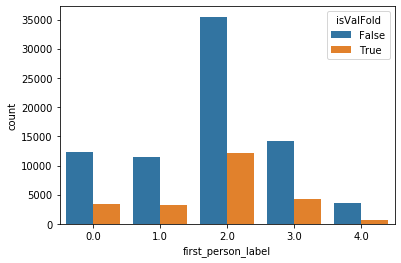

In [3]:
sns.countplot(x='first_person_label',hue='isValFold',data=df)

In [7]:
train_df = df[['index','label','isValFold']]
train_df['index'] = [s.replace('.mp4','_0_0.png') for s in train_df['index'].values]

# oversample reals (with different frames)
sample_frames_per_real_video = 17
sample_frames_per_fake_video = 3
train_real = train_df[train_df['label'] == 'REAL']
train_fake = train_df[train_df['label'] == 'FAKE']
dfs = []
for i in range(sample_frames_per_real_video):
    df_temp = train_real.copy(deep=True)
    df_temp['index'] = [s.replace('0.png',str(i)+'.png') for s in train_real['index'].values]
    dfs.append(df_temp)
    
for i in range(sample_frames_per_fake_video):
    j = i*6 #take the samples more apart
    df_temp = train_fake.copy(deep=True)
    df_temp['index'] = [s.replace('0.png',str(j)+'.png') for s in train_fake['index'].values]
    dfs.append(df_temp)

train_df = pd.concat(dfs, ignore_index=True)

/home/joni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
train_df.tail()

,index,label,isValFold
506876,bdtnxarnwm_0_12.png,FAKE,False
506877,jiqnlxpoul_0_12.png,FAKE,False
506878,nxpcjfmeib_0_12.png,FAKE,True
506879,eqvzvbzbtc_0_12.png,FAKE,False
506880,ddsqqjrjax_0_12.png,FAKE,False


Get sampled real-fake face pairs.

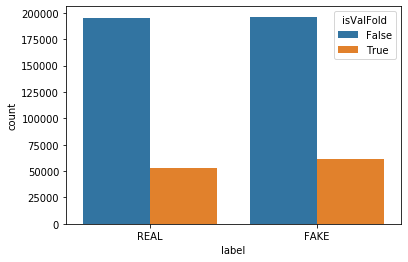

In [11]:
sns.countplot(x='label',hue='isValFold',data=train_df)

# Train

In [13]:
tfms = get_transforms(max_zoom=1.2,#1.0, 
                      max_rotate=5,#0, 
                      max_warp=0.0,#0,
                      max_lighting=0.4) # no zoom, rotate or warp because of the reflect padding
data = (ImageDataBunch.from_df(path=IMAGE_DIR, df=train_df)
        .split_from_df('isValFold')
       .label_from_df('label')
       .transform(tfms)
       .databunch(bs=32)
       .normalize(stats=imagenet_stats))

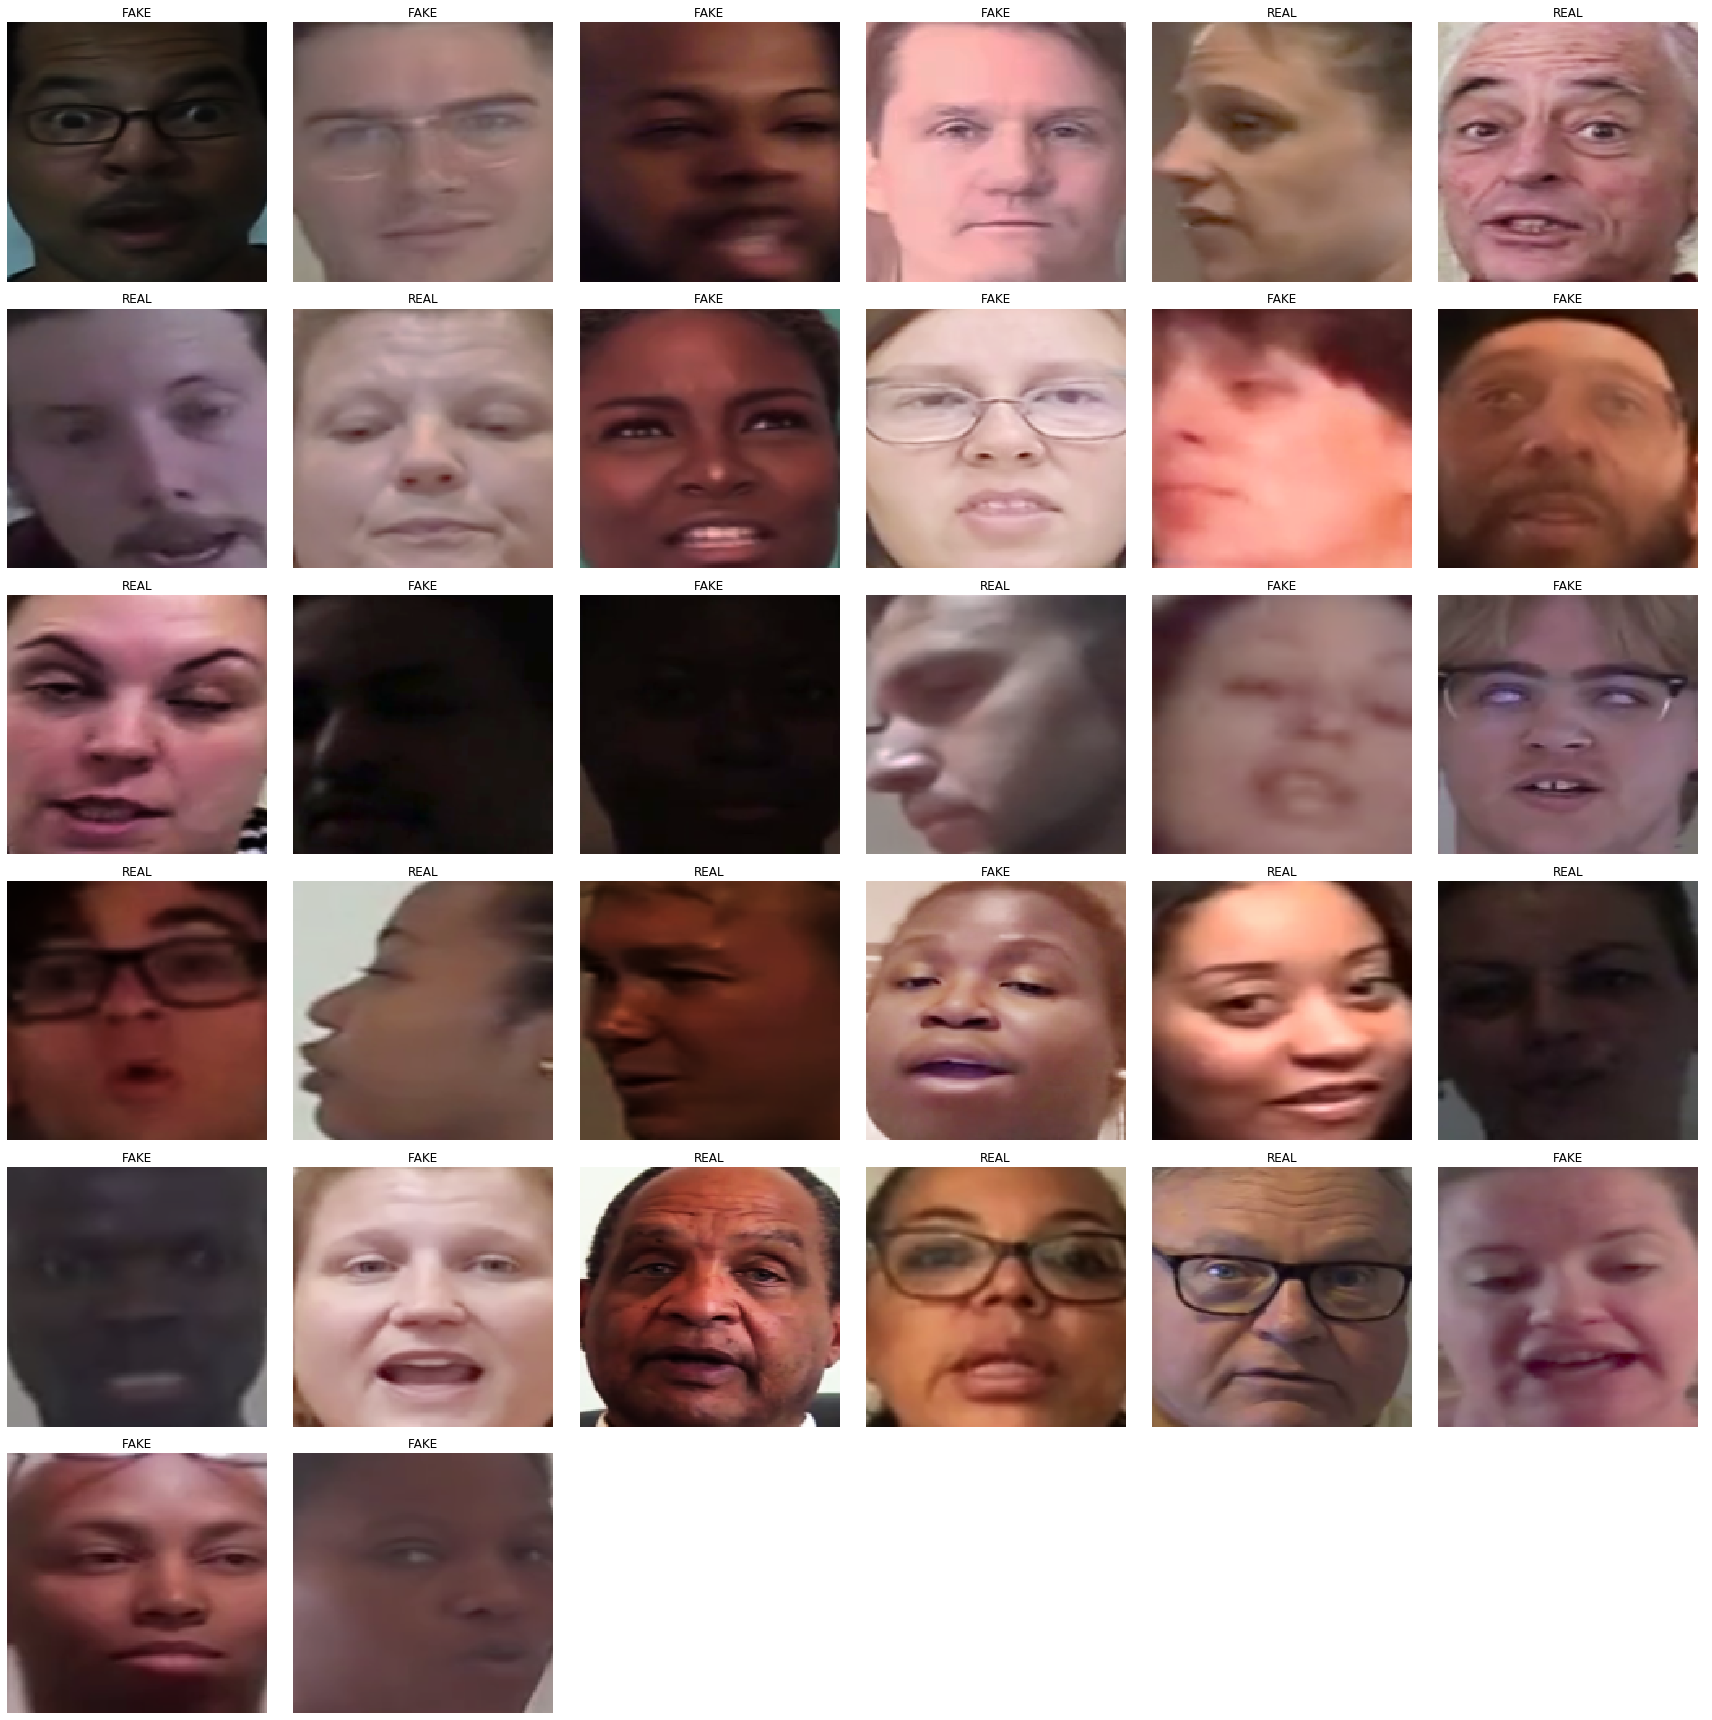

In [14]:
data.show_batch(6)

In [15]:
from util.PretrainedModels import xception

In [16]:
cbs = [ShowGraph]

learn =  cnn_learner(data,
                     xception,
                     pretrained=True,
                     metrics=[accuracy, error_rate], 
                     ps=0.4,
                     callback_fns=cbs)

In [17]:
learn.freeze() # this leaves only the head for training
len(learn.layer_groups)

2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


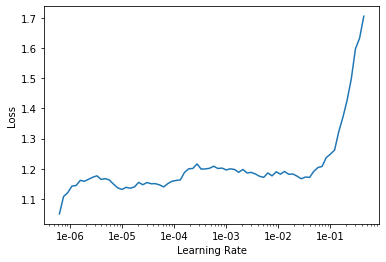

In [18]:
learn.lr_find()
learn.recorder.plot()

## Train head only

Start with one-cycle.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.358385,0.427488,0.804910,0.195090,23:10


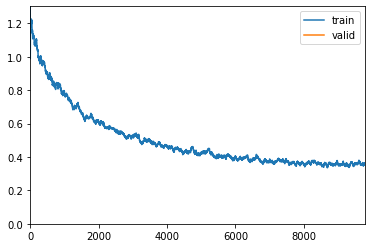

In [19]:
learn.fit_one_cycle(1, 1e-3)

In [20]:
learn.save('temp') # save, just in case we need to start over the next step

## Train the whole model

Use reduce-lr-on-plateau and train as long as the `valid_loss` improves. Save only the best model.

In [21]:
learn.unfreeze() #train all layers

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.183172,0.377862,0.848601,0.151399,34:09
1,0.112957,0.468589,0.827602,0.172398,33:57


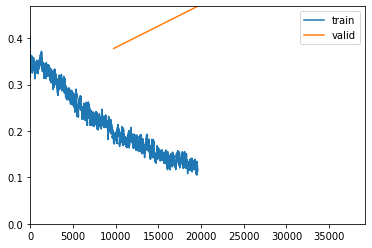

Better model found at epoch 0 with valid_loss value: 0.3778623342514038.


KeyboardInterrupt: 

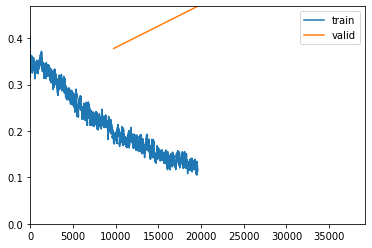

In [22]:
n_epochs = 4
lrs = [1e-4,8e-4] # use different lr for different layer groups

save_cb = SaveModelCallback(learn,
                            every='improvement', 
                            monitor='valid_loss', 
                            name='best')
reduce_lr_cb = ReduceLROnPlateauCallback(learn,
                                         monitor='valid_loss',
                                         patience=0,
                                         factor=0.2,
                                         min_delta=0.01,
                                         min_lr=0.000001)
early_stop_cb = EarlyStoppingCallback(learn,
                                      patience=3)

learn.fit_one_cycle(n_epochs, lrs, callbacks=[save_cb])
                                    #reduce_lr_cb, 
                                    #early_stop_cb])

# Export the model

In [23]:
# load best
learn.load('best')

Learner(data=ImageDataBunch;

Train: LabelList (313404 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
REAL,REAL,REAL,REAL,REAL
Path: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_faces_2;

Valid: LabelList (92101 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
REAL,REAL,REAL,REAL,REAL
Path: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_faces_2;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bi

In [24]:
if not os.path.exists('../models/large_face_classifier'):
    os.mkdir('../models/small_face_classifier')
os.mkdir('../models/small_face_classifier/2020_02_24-f3')

In [25]:
learn.export(file="/mnt/945C2D6E5C2D4BF4/Kaggle/deepfake-video-detection/models/small_face_classifier/2020_02_24-f3/export.pkl")

# Error analysis

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

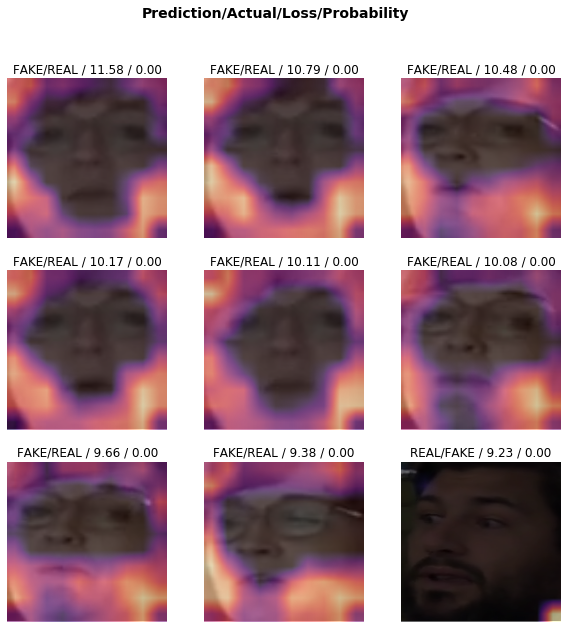

In [27]:
interp.plot_top_losses(9, figsize=(10,10), heatmap=True)

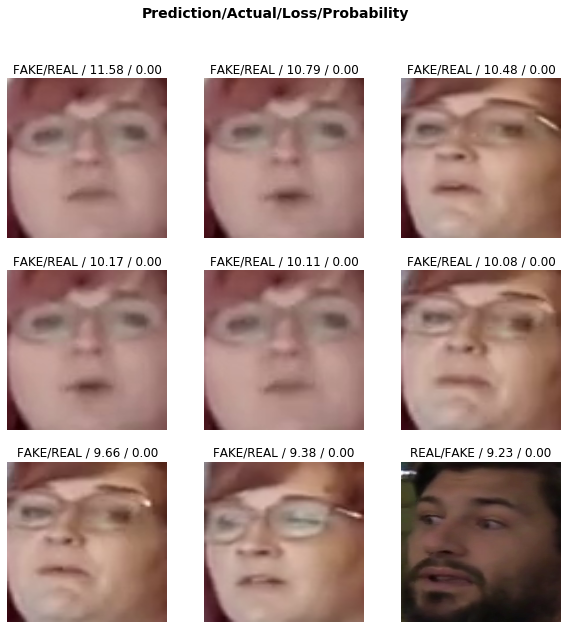

In [28]:
interp.plot_top_losses(9, figsize=(10,10), heatmap=False)

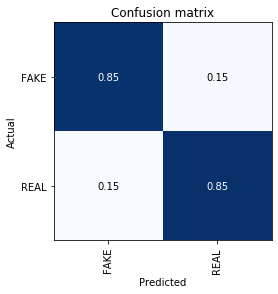

In [29]:
interp.plot_confusion_matrix(normalize=True)

## Plot some random samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


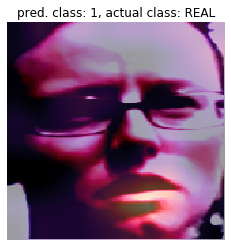

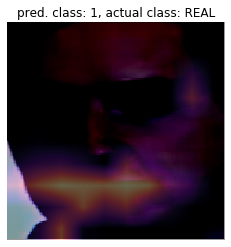

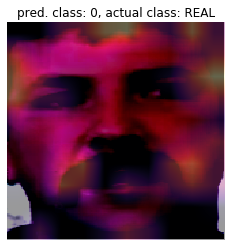

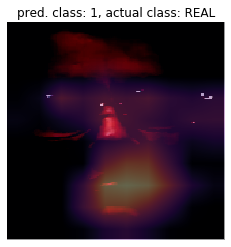

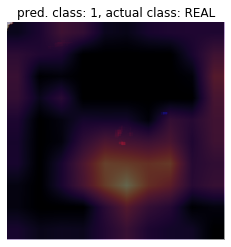

In [30]:
import random
for i in range(5):
    interp.GradCAM(random.randint(0,1000))

In [32]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm
from fastai.vision import *

def getFrameLabel(df, df_index, frame_index, person_index=0):
        # get array of frame labels from the dataframe
        frame_lbl_col = 'first_person_frame_labels' if person_index==0 else 'second_person_frame_labels'
        frame_labels = df.loc[df_index,frame_lbl_col]
        
        # check for nan
        if frame_labels == np.nan:
            return np.nan
        
        lbls_int = [int(lbl) for lbl in str(frame_labels).replace('[','').replace(']','').replace(' ','').split(',')]
        return lbls_int[frame_index]
    
def extractIdFromPath(pth):
    parts = pth.split('/')[-1].split('_')
    return parts[0] + '.mp4', int(parts[2].replace('.png',''))
    
def getGtsNPreds(interp):
    ys = []
    preds = []
    for (pth, pred_tensor) in tqdm(zip(list(interp.data.valid_ds.items),list(interp.preds)),total=len(interp.data.valid_ds.items)):
        pred = pred_tensor[1].numpy() > 0.5
        img_id, frame_index = extractIdFromPath(pth)
        df_index = df[df['index']==img_id].index.values[0]
        frame_lbl = getFrameLabel(df, df_index, frame_index)
        ys.append(frame_lbl)
        preds.append(frame_lbl if (pred==(frame_lbl==0)) else int(not pred))
    return ys, preds

In [33]:
ys, preds = getGtsNPreds(interp)

In [34]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(ys,preds)

In [35]:
confusion_mat

array([[37499,  7640,     0,     0,     0],
       [ 2634, 10767,     0,     0,     0],
       [ 3215,     0, 22972,     0,     0],
       [  492,     0,     0,  5995,     0],
       [   29,     0,     0,     0,   858]])

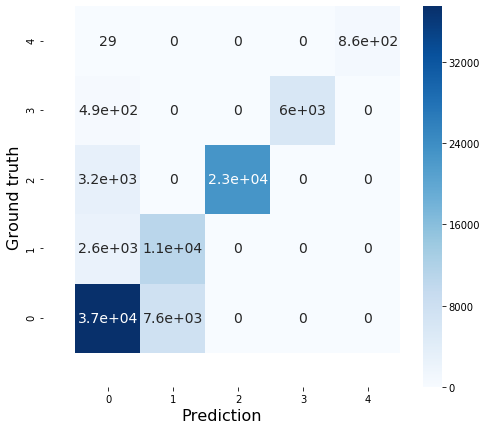

Real type 0 REAL/FAKE binary classification accuracy 83.1 %
Fake type category 1 REAL/FAKE binary classification accuracy 80.3 %
Fake type category 2 REAL/FAKE binary classification accuracy 87.7 %
Fake type category 3 REAL/FAKE binary classification accuracy 92.4 %
Fake type category 4 REAL/FAKE binary classification accuracy 96.7 %


In [36]:
df_cm = pd.DataFrame(confusion_mat, index = list(range(5)),
                  columns = list(range(5)))
plt.figure(figsize = (8,7))
sns.heatmap(df_cm, annot=True, cmap='Blues',annot_kws={"size": 14})
plt.xlim(-0.5,5)
plt.ylim(-0.5,5)
plt.ylabel('Ground truth',fontsize=16)
plt.xlabel('Prediction',fontsize=16)
plt.show()

for lbl_ind in range(5):
    right = confusion_mat[lbl_ind][lbl_ind]
    wrong = confusion_mat[lbl_ind][0 if lbl_ind > 0 else 1]
    print('{2} {0} REAL/FAKE binary classification accuracy {1:.1f} %'.format(lbl_ind,
                                                                              100*right/(right+wrong),
                                                                              'Fake type category' if lbl_ind > 0 else 'Real type'))